In [1]:
import os
import argparse

from pedes.function.config import config, update_config
from pedes.function.test import test_net

import pprint
import shutil

import json
from tqdm import tqdm, trange
import numpy as np
import torch
import torch.nn.functional as F

from common.utils.load import smart_load_model_state_dict
from common.trainer import to_cuda
from common.utils.create_logger import create_logger
from common.utils.clip_pad import *
from pedes.data.build import make_dataloader, build_transforms
from pedes.modules import *
#from pedes.data.build.transforms.build import build_transforms

from external.pytorch_pretrained_bert import BertTokenizer
from PIL import Image


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
def parse_args():
    parser = argparse.ArgumentParser('Train Cognition Network')
    parser.add_argument('--cfg', type=str, help='path to config file', default='../cfgs/pedes/VS_small_6.yaml')
    parser.add_argument('--ckpt', type=str, help='root path to store checkpoint', default='../../back_model/VS_small_6.model')
    parser.add_argument('--method', type=str, help='name of the different cutting method', default='VS_small_6')
    # OS_small_11 VS_small_6 KS_small     method
    parser.add_argument('--gpus', type=int, nargs='+', help='indices of GPUs to use', default=[0])
    parser.add_argument('--bs', type=int)
    parser.add_argument('--split', type=str, choices=['test', 'testA', 'testB', 'val'], default='val')
    parser.add_argument('--result-path', type=str, help='dir to save result file', default='./')
    parser.add_argument('--result-name', type=str, help='name of result file', default='answer')

    args = parser.parse_args(args=[])

    if args.cfg is not None:
        update_config(args.cfg)

    return args, config

In [3]:
def image_feat_load(path):
    # path_image = self.data_path + "/imgs/" + annotation['file_path']
    transform = build_transforms(config, mode='val')
    image = Image.open(path).convert('RGB')
    im_info = torch.as_tensor([image.width, image.height, 1.0, 1.0])
    flipped = False
    
    if args.method == 'VS_small_6':
        boxes = []
        height_change = image.height / 6 * 1.0
        for i in range(6):
            boxes.append([0, height_change * i, image.width, height_change * (i + 1)])
        boxes = torch.as_tensor(boxes)
    elif args.method == 'OS_small_11':
        part = 6
        number_sep = 2
        number_parts = number_sep * part - number_sep + 1
        boxes = []
        height_change = image.height / part * 1.0
        for i in range(number_parts):
            boxes.append(
                [0, height_change * i / number_sep, image.width, height_change * (i / number_sep + 1)])
        boxes = torch.as_tensor(boxes)
    elif args.method == 'KS_small':
        f_box = open(os.path.join('/home/lihui/datasets/ps-language', 'result.json')) #box_frcnn.json
        JPP_boxes = json.load(f_box)
        path_key = path.split('/')[-2] +'/' + path.split('/')[-1]
        boxes = JPP_boxes[path_key].copy()
        boxes = torch.as_tensor(boxes).float()

    w0, h0 = im_info[0], im_info[1]
    image_box = torch.as_tensor([[0.0, 0.0, w0 - 1, h0 - 1]])
    boxes_o = torch.cat((image_box, boxes), dim=0)
    
#     print(boxes_o)
    
    if transform is not None:
        image, boxes, _, im_info, flipped = transform(image, boxes_o.clone(), None, im_info, flipped)
    w = im_info[0].item()
    h = im_info[1].item()
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clamp(min=0, max=w - 1)
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clamp(min=0, max=h - 1)

    image_b = image.unsqueeze(0)
    boxes_b = boxes.unsqueeze(0)
    im_info_b = im_info.unsqueeze(0)

    box_mask = (boxes_b[:, :, 0] > - 1.5)
    obj_reps = model.image_feature_extractor(images=image_b.cuda(),
                                            boxes=boxes_b.cuda(),
                                            box_mask=box_mask.cuda(),
                                            im_info=im_info_b.cuda(),
                                            classes=None,
                                            segms=None)

    return obj_reps['obj_reps'], image_b, boxes_b, im_info_b, boxes_o

In [4]:
def text_feat_load(sentence):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    exp_retokens = tokenizer.tokenize(sentence)
    exp_ids = tokenizer.convert_tokens_to_ids(exp_retokens)

    max_expression_length = 50  # max([len(exp_ids), len(exp_ids2), len(exp_ids3)])
    exp_ids = clip_pad_1d(exp_ids, max_expression_length, pad=0)
    exp_ids_b = exp_ids.unsqueeze(0)
    return exp_ids_b

In [5]:
cd pedes

/home/lihui/VM/model/pedes


In [6]:
args, config = parse_args()
config.DATASET.TEST_IMAGE_SET = args.split
ckpt_path = args.ckpt

model = eval(config.MODULE)(config)
model = model.cuda()
checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
print(ckpt_path)
smart_load_model_state_dict(model, checkpoint['state_dict'])

model.eval()



/home/lihui/VM/model/pedes/function/config.py:181: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))
/home/lihui/VM/model/common/backbone/resnet/resnet.py:214: UserWarning: miss keys: ['bn1.num_batches_tracked', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.bn2.num_batches_tracked', 'layer1.1.bn3.num_batches_tracked', 'layer1.2.bn1.num_batches_tracked', 'layer1.2.bn2.num_batches_tracked', 'layer1.2.bn3.num_batches_tracked', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.bn2.num_batches_tracked', 'layer2.0.bn3.num_batches_tracked', 'layer2.0.downsample.1.num_batches_tracked', 'layer2.1.bn1.num_batches_tracked', 'layer2.1.bn2.num_batches_tracked', 'layer2.1.bn3.num_batches_tracked', 'layer2.2.b

Warnings: Unexpected keys: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.gamma', 'cls.predictions.transform.LayerNorm.beta', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias'].
../../back_model/KS_small.model


In [7]:
#obj_reps['obj_reps'], image_b, boxes_b, im_info_b, annotation['id']
image_path = "/home/lihui/datasets/ps-language/imgs/train_query/p260_s495.jpg"
sent = "The woman wears a shirt, black pants, and blue tennis shoes. She wears glasses and carries a red backpack."
feats, image_b, boxes_b, im_info_b, boxes_o = image_feat_load(image_path)
batch_b = text_feat_load(sent)

image_b = image_b.unsqueeze(0)
boxes_b = boxes_b.unsqueeze(0)
im_info_b = im_info_b.unsqueeze(0)

batch_test = to_cuda([image_b, boxes_b, im_info_b, batch_b.unsqueeze(0), 0, feats])

att ,sim = model(*batch_test)
print(sim)

tensor([[6.1775]], device='cuda:0', grad_fn=<AddmmBackward>)


In [8]:
input_id_list = batch_b[0].tolist() # Batch index 0
print(input_id_list)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
print(tokens)

[1996, 2450, 11651, 1037, 3797, 1010, 2304, 6471, 1010, 1998, 2630, 5093, 6007, 1012, 2016, 11651, 7877, 1998, 7883, 1037, 2417, 13383, 1012, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['the', 'woman', 'wears', 'a', 'shirt', ',', 'black', 'pants', ',', 'and', 'blue', 'tennis', 'shoes', '.', 'she', 'wears', 'glasses', 'and', 'carries', 'a', 'red', 'backpack', '.', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [9]:
cd /home/lihui/VM/model

/home/lihui/VM/model


In [10]:
from bertviz import head_view
import matplotlib.pyplot as plt
import cv2

def show_features(boxes, attrs):
    for i in range(len(boxes)):
        bbox = boxes[i]
        plt.gca().add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.8))
        plt.gca().text(bbox[2]+20, bbox[1]+10,
            '%s' % (attrs[i]),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=8, color='white')

In [11]:
num_sentence = (batch_b[0] != 0).sum()

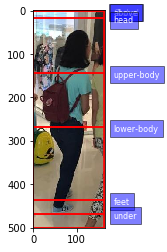

In [12]:
sents = ['[CLS]']
sents += tokens[:num_sentence][:]
sents += ['[SEP]']
if args.method == 'VS_small_6':
    att_tag = ['Global','P0','P1','P2','P3','P4','P5','[END]']
elif args.method == 'OS_small_11':
    att_tag = ['Global','P0','P0.5','P1','P1.5','P2','P2.5','P3','P3.5','P4','P4.5','P5','[END]']
else:
    att_tag = ['Global','above','head','upper-body','lower-body','feet','under','[END]'] #lank space above the head, the head,upper-body,  lower-body,  feet  and  the  blank  space  under  feet
sents += att_tag

im = cv2.imread(image_path)
rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(rgb)
show_features(boxes_o, att_tag)
plt.show()

# display(Image.open(image_path))

In [13]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [14]:
att[10][att[10] < 0.2] = 0

In [15]:
head_view(att, sents, num_sentence+2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>